<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/nifty_%25_above_50_dma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
nifty50_url = "https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()
# Bank Nifty Stocks
nifty_stocks = tickers

def calculate_percentage_above_moving_average(stock_list,periods,start_date):
    data = yf.download(stock_list, start=start_date)
    data = data['Adj Close']

    # Calculate the moving average using ewm with min_periods set to 50
    ma = data.ewm(span=periods, min_periods=periods).mean()

    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / len(stock_list)) * 100

    return percentage

# Calculate the percentage of stocks above their 200 DMA for each day
percentage_above_dma = calculate_percentage_above_moving_average(nifty_stocks,200,'2022-01-01')
percentage_50_dma=calculate_percentage_above_moving_average(nifty_stocks,50,'2022-01-01')
# Download the Bank Nifty index data
nifty = yf.download('^NSEI', start='2022-01-01')

# Reindex Bank Nifty index data to match percentage_above_dma
aligned_nifty_close = nifty['Adj Close'].reindex(percentage_above_dma.index)




/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
percentage_above_dma_30_ema=percentage_50_dma.rolling(window=30).mean()
percentage_above_dma_10_ema=percentage_50_dma.rolling(window=10).mean()

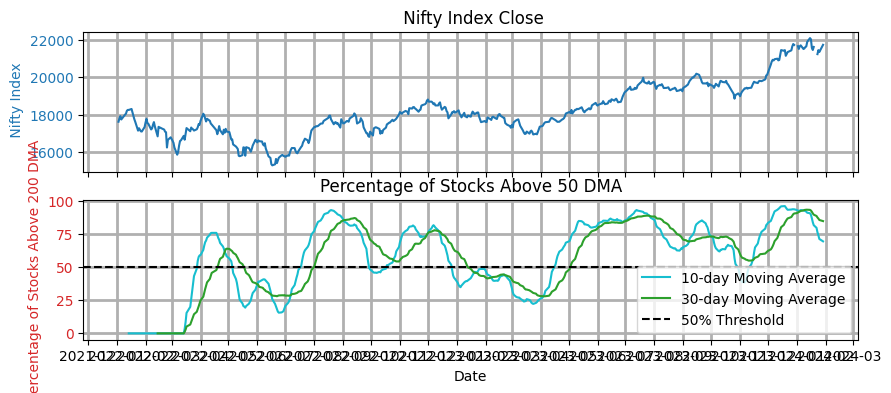

In [4]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel(' Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(' Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
#ax2.plot(percentage_above_dma.index, percentage_above_dma, color='tab:red', label='Percentage Above 200 DMA')
ax2.plot(percentage_50_dma.index, percentage_above_dma_10_ema, color='tab:cyan', label='10-day Moving Average')
ax2.plot(percentage_50_dma.index, percentage_above_dma_30_ema, color='tab:green', label='30-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 50 DMA')
ax2.axhline(y=50, color='black', linestyle='dashed', label='50% Threshold')
ax2.legend()

yloc = YearLocator()
mloc = MonthLocator()
ax1.xaxis.set_major_locator(mloc)
ax2.xaxis.set_major_locator(mloc)
#ax[2].xaxis.set_major_locator(mloc)
ax1.grid(linewidth =2)
ax2.grid(linewidth =2)
#ax[2].grid(linewidth =2)


plt.show()


In [5]:
signal=np.where(percentage_above_dma_10_ema>percentage_above_dma_30_ema,1,0)
result=percentage_above_dma_10_ema-percentage_above_dma_30_ema

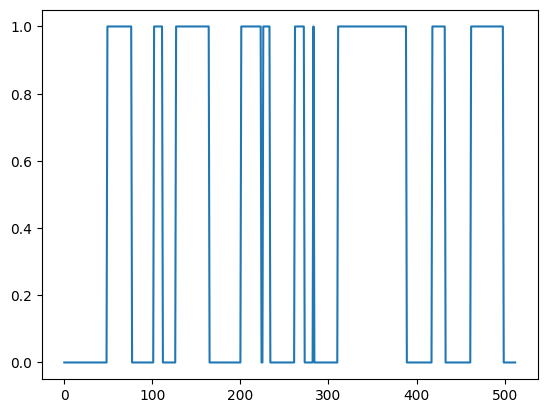

In [6]:
pd.Series(signal).plot();

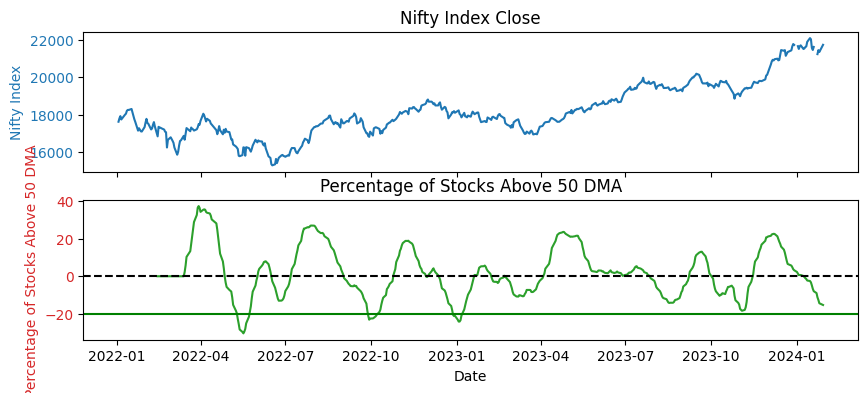

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel('Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 50 DMA', color='tab:red')
ax2.plot(percentage_50_dma.index,result, color='tab:green', label='Percentage Above 50 DMA-(30ema-10ema) smoothing everage')

ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 50 DMA')
ax2.axhline(y=0, color='black', linestyle='dashed', label='50% Threshold')
ax2.axhline(y=-20, color='green', label='buy here or at Divergence')
#ax2.legend(loc='upper left')
plt.show()


In [8]:
signal[-1]

0

In [9]:
signal[-5:]

array([0, 0, 0, 0, 0])

In [10]:
result[-5:]

Date
2024-01-22    -8.933333
2024-01-23   -11.200000
2024-01-24   -12.600000
2024-01-25   -14.333333
2024-01-29   -15.266667
dtype: float64

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [12]:
regre= pd.DataFrame()

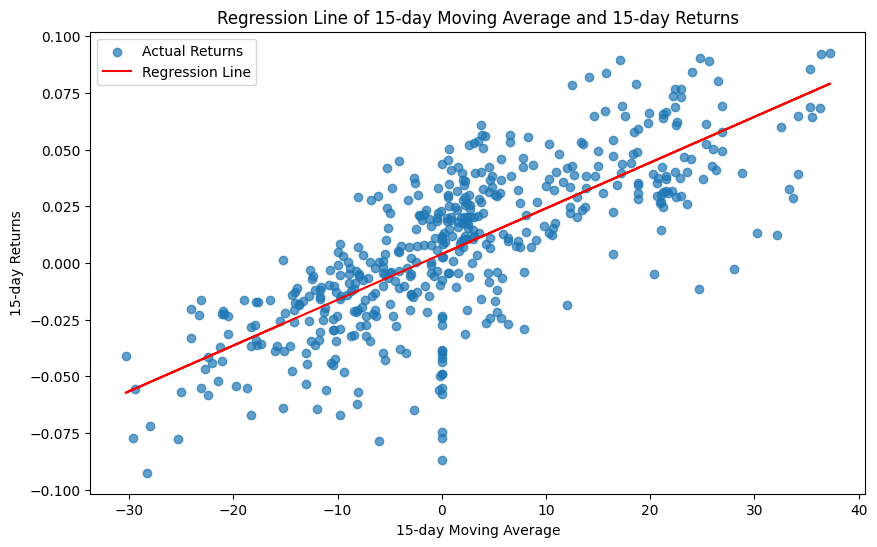

In [13]:
# Calculate the 15-day moving average
regre['MA_15'] = result

# Calculate 15-day returns
regre['Returns_15'] = aligned_nifty_close.pct_change(periods=15)

# Drop NaN values
regre = regre.dropna()

# Prepare data for regression
X = regre[['MA_15']]
y = regre['Returns_15']

# Train linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict returns using the regression line
regre['Predicted_Returns'] = model.predict(X)

# Plot the results
plt.figure(figsize=(10, 6))

plt.scatter(regre['MA_15'], regre['Returns_15'], label='Actual Returns', alpha=0.7)
plt.plot(regre['MA_15'], regre['Predicted_Returns'], color='red', label='Regression Line')

plt.title('Regression Line of 15-day Moving Average and 15-day Returns')
plt.xlabel('15-day Moving Average')
plt.ylabel('15-day Returns')
plt.legend()
plt.show()